In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1660 SUPER


### Read data file to dataframe --> convert to numpy array

In [3]:
fname = "1. Data - Iris.xlsx"  #the data file is located at the same directory
df=pd.read_excel(fname)
df.head(5)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
df.columns

Index(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width',
       'Species'],
      dtype='object')

In [5]:
dfX = df[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']]
dfY = df['Species']

In [6]:
#convert dfY from string to integer 0, 1, 2
lstY1 = dfY.values.tolist()
lstY = []
for elt in lstY1:
  if(elt == 'setosa'):
    lstY.append(0)
  elif (elt == 'versicolor'):
    lstY.append(1)
  elif (elt == 'virginica'):
    lstY.append(2)
  else:
    print("Wrong label", elt)

In [7]:
#convert data to numpy array
numpyX = np.array(dfX.values)
numpyY = np.array(lstY)
print(numpyX.shape, numpyY.shape)

(150, 4) (150,)


### Split input data to train and test data

In [8]:
trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(120, 4) (30, 4) (120,) (30,)


### Define NN

In [9]:
MyNet = nn.Sequential(
    nn.Linear(4, 56),
    nn.Dropout(p=0.5),
    nn.Sigmoid(),
    nn.Linear(56, 56),
    nn.Dropout(p=0.5),
    nn.Sigmoid(),
    nn.Linear(56, 3),
)
MyNet.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=56, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=56, out_features=56, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=56, out_features=3, bias=True)
)

### Train NN

In [10]:
train_lossLst = []
validation_lossLst = []

In [11]:
# split training data to train and validation
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.20, random_state=0)
tensor_trainX = torch.FloatTensor(trainX).to(device)
tensor_trainY = torch.LongTensor(trainY).to(device)

tensor_validationX = torch.FloatTensor(validationX).to(device)
tensor_validationY = torch.LongTensor(validationY).to(device)

In [12]:
print(tensor_trainX.shape, tensor_trainY.shape, tensor_validationX.shape, tensor_validationY.shape)

torch.Size([96, 4]) torch.Size([96]) torch.Size([24, 4]) torch.Size([24])


In [13]:
BATCH_SIZE = 16   #try 1/5, 1/10, 1/15 of the training data

In [14]:
# define data loader
torch_dataset = Data.TensorDataset(tensor_trainX, tensor_trainY)
loader = Data.DataLoader(
    dataset=torch_dataset,  
    batch_size=BATCH_SIZE,      
    shuffle=True,       
    num_workers=0,   
)

In [15]:
# initialize NN weights
for name, param in MyNet.named_parameters():
  if(param.requires_grad):
    torch.nn.init.normal_(param, mean=0.0, std=0.02)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003)

In [16]:
# train NN 
epoch_lossLst=[]
for epoch in range(1, 500):
  if(epoch%100 == 0):
    print(epoch, end=",")
  for (batchX, batchY) in loader:
    batchY_hat = MyNet(batchX)
    loss = loss_func(batchY_hat, batchY)
    epoch_lossLst.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg = sum(epoch_lossLst) / len(epoch_lossLst)
  train_lossLst.append(avg) 

  with torch.no_grad():
      tensor_validationY_hat = MyNet(tensor_validationX)
      tensor_validationY = tensor_validationY.view(-1)
      validatiion_loss = loss_func(tensor_validationY_hat, tensor_validationY)
      validation_lossLst.append(float(validatiion_loss))

100,200,300,400,

In [17]:
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%m-%d-%H-%M-%S")
print(formatted_time)

05-07-09-22-40


In [18]:
# save model of this training
fname = formatted_time + ".pth"
torch.save(MyNet.state_dict(), fname)

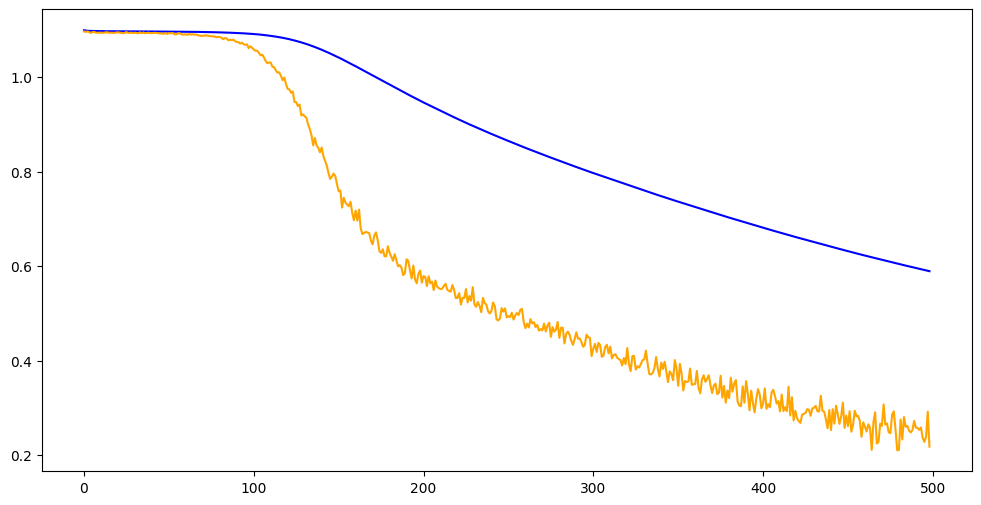

In [20]:
fig=plt.figure(figsize=(12, 6))
plt.plot(train_lossLst, color='blue')
plt.plot(validation_lossLst, color='orange')
plt.show()

### Mannually go back to train again --> observe train, validation loss --> train again...

### After train several times, pick up the best model

In [21]:
# Load the best model
MyNet.load_state_dict(torch.load('05-07-09-22-40.pth'))

<All keys matched successfully>

In [22]:
MyNet.eval()
MyNet.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=56, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=56, out_features=56, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=56, out_features=3, bias=True)
)

In [24]:
tensor_testX = torch.FloatTensor(testX).to(device)
tensor_testY = torch.LongTensor(testY).to(device)

In [25]:
tensor_testY_hat = MyNet(tensor_testX)
tensor_testY_hat = torch.softmax(tensor_testY_hat, 1)
MaxIdxOfEachRow = torch.max(tensor_testY_hat, 1)[1]

In [26]:
conf_matrix = confusion_matrix(tensor_testY.cpu().numpy(), MaxIdxOfEachRow.cpu().numpy())

<Axes: >

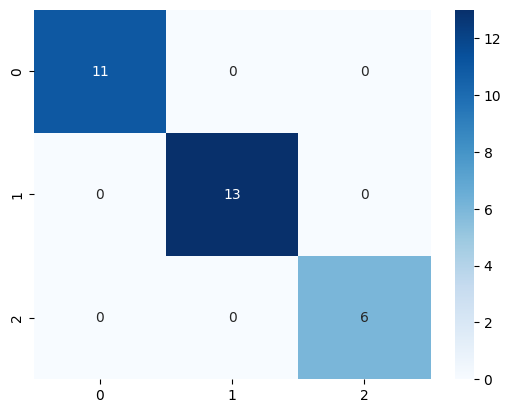

In [27]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')